# Computing the nonadiabatic couplings in Kohn-Sham and excited states bases in extended tight-binding framework

In this tutorial, we will start computing the nonadiabatic couplings (NACs) from the molecular orbital overlap files obtained in [step2](../../7_step2_cp2k/2_xTB). The NACs will be computed in Kohn-Sham states but only in single-partcile (SP) excited state basis, not many-body (MB) states, because we did not perform TD-DFT. Finally we will plot the excited states energies vs time and NAC map.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Computing the NACs](#comp_nacs)     
    3.1. [Kohn-Sham basis](#KS)\
    3.2. [Excited state basis](#excited_states)
4. [Plotting the results](#plotting)\
    4.1. [NAC distribution](#nac_dist)\
    4.2. [Energy vs time](#ene_time)\
    4.3. [NAC map](#nac_map)\
    4.4. [Average partial density of states](#ave_pdos)
    - 4.4.1. [Plot pDOS for all atoms angular momentums](#ave_pdos_1)
    - 4.4.2. [Plot pDOS for atoms with no angular momentum component](#ave_pdos_2)

### A. Learning objectives

* To be able to compute the NACs in Kohn-Sham and excited state basis
* To be able to plot the NACs distribution 
* To be able to plot the computed excited states energies vs time
* To be able to plot the NAC map
* To be able to plot the average partial density of states

### B. Use cases

* [Computing the NACs](#comp_nacs)
* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `data_stat`
    -  `cmat_distrib`
  - `workflows`
    - `nbra`
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `units`
    - `au2ev`


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library so that we can read and check the orthonormality of the data.
Import `numpy`, `scipy.sparse`, `data_stat`, `data_io`, `units`, and `step3` modules. Also, `glob` will be needed to find specific types of files.

In [1]:
import os
import sys
import time
import glob
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py.workflows.nbra import step3
from libra_py import units, data_stat, data_io

/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/import

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

* `../../7_step2_cp2k/1_xTB/2_hpc/res`

The MO overlap files are needed and stored in this folder.

* `../../7_step2_cp2k/1_xTB/2_hpc/all_logfiles`

All of the logfiles obtained from the electronic structure calculations of CP2K. These files will be needed to find the Kohn-Sham HOMO index. 

## 3. Computing the NACs <a name="comp_nacs"></a>
[Back to TOC](#toc)

### 3.1. Kohn-Sham basis <a name="KS"></a>

The `libra_py.workflow.nbra.step3.run_step3_ks_nacs_libint(params)` computes the NACs between pairs of Kohn-Sham states using the molecular orbital 
overlaps. The paramters for this function are as follows:

`params['lowest_orbital']`: The lowest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['highest_orbital']`: The highest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['num_occ_states']`: The number of occupied orbitals to be considered from HOMO to lower occupied states. This value is defined by user.

`params['num_unocc_states']`: The number of unoccupied orbitals to be considered from LUMO to higher unoccupied states. This value is defined by user.

The two values above are used to create an active space which then will be used to select the elements from the MO overlap and energy matrices.

`params['use_multiprocessing']`: A boolean flag to use the multiprocessing library of Python or not.

`params['nprocs']`: The number of processors to be used for the calculations. Libra will use this only if the `params['use_multiprocessing']` 
is set to `True`.

`params['time_step']`: The time-step used in the calculations in `fs`.

`params['es_software']`: The name of the software package used to compute the electronic structure calculations. This will be used to generate the HOMO 
index of that system so it can build the active space.

`params['path_to_npz_files']`: The full path to the MO overlap files.

`params['logfile_directory']`: The full path to the folder where all the log files are stored.

`params['path_to_save_ks_Hvibs']`: The full path to the folder in which the NACs between the Konh-Sham states are stored.

`params['start_time']`: The start time-step.

`params['finish_time']`: The finish time-step.

`params['apply_phase_correction']`: A boolean flag for applying phase-correction algorithm.

`params['apply_orthonormalization']`: A boolean flag for applying the orthonormalization algorithm.

`params['do_state_reordering']`: If this value is set to `1` or `2`, the state-reordering will be applied to overlap matrices.

`params['state_reordering_alpha']`: The state-reordering alpha value if the `params['do_state_reordering'] = 2`.

After setting all the above paramters, the calculations are run using `step3.run_step3_ks_nacs_libint(params)`.

In [3]:
params_ks = {
          'lowest_orbital': 128-20, 'highest_orbital': 128+21, 'num_occ_states': 20, 'num_unocc_states': 20,
          'use_multiprocessing': True, 'nprocs': 8, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/res',
          'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_logfiles',
          'path_to_save_ks_Hvibs': os.getcwd()+'/res-ks-xTB',
          'start_time': 1500, 'finish_time': 1700,
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0
         }

#### For KS states - Applying correction to KS overlaps and computing the NACs in KS space
step3.run_step3_ks_nacs_libint(params_ks)

Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step  1521   1514 
15281535
15421549Computing orthonormalization of St matrices in step



 1500
Computing orthonormalization of St matrices in step 1507
Done with stepDone with step  15281549Done with step  Done with step . Elapsed time:. Elapsed time: 1500 Done with step1542 Done with step 0.5503044128417969. Elapsed time: 0.6102347373962402
0.5455348491668701 . Elapsed time: 0.6355774402618408
Computing orthonormalization of St matrices in step
 Computing orthonormalization of St matrices in step 1501
 
15431514Computing orthonormalization of St matrices in step Computing orthonormalization of St matrices in step 
  15501535. Elapsed time:1529Done with step
 Done with step  
0.672087430

Done with step Done with step Done with step1558Done with step   1592. Elapsed time:15861578   . Elapsed time: . Elapsed time:0.5233604907989502. Elapsed time:  
 Computing orthonormalization of St matrices in step0.57815504074096680.60925340652465820.2781486511230469


Computing orthonormalization of St matrices in step Done with stepComputing orthonormalization of St matrices in step1559Computing orthonormalization of St matrices in step    Done with step
1593
1579 1587

15651599 . Elapsed time: 0.5485913753509521
Computing orthonormalization of St matrices in step 1600
Done with step 1606 . Elapsed time: 0.40023303031921387 . Elapsed time: 0.7041900157928467
Computing orthonormalization of St matrices in step 
1566
Done with stepComputing orthonormalization of St matrices in step  15721607 Done with step . Elapsed time:
1600 0.5636703968048096Done with step 
. Elapsed time:Computing orthonormalization of St matrices in stepDone with step  1573
1587 Done with step0.27739834785461426 

. Elapsed time:1664 
0.5192124843597412Done with stepDone with step  Done with stepDone with step 1637 1616
1643 1657 Computing orthonormalization of St matrices in step . Elapsed time:. Elapsed time:. Elapsed time:    0.619175910949707 16510.5373632907867432. Elapsed time:

0.3807337284088135 

Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step Computing orthonormalization of St matrices in step1617
 0.5484216213226318
Computing orthonormalization of St matrices in step1658 1638 
1644

Done with step 1624 . Elapsed time: 0.6268448829650879
Done with step Done with stepComputing orthonormalization of St matrices in step1630   . Elapsed time: 16251664 . Elapsed time:0.578972578048706
Done with step
  Computing orthonormalization of St matrices in step 1631
0.65890884399414061651
 . Elapsed time: 0.4853334426879883
Computing orthonormalization of St matrices in stepDone with step Computing orthonormalization of St matrices in step 1652 

Applying phase-correction to step 1548
Applying phase-correction to step 1549
Applying phase-correction to step 1550
Applying phase-correction to step 1551
Applying phase-correction to step 1552
Applying phase-correction to step 1553
Applying phase-correction to step 1554
Applying phase-correction to step 1555
Applying phase-correction to step 1556
Applying phase-correction to step 1557
Applying phase-correction to step 1558
Applying phase-correction to step 1559
Applying phase-correction to step 1560
Applying phase-correction to step 1561
Applying phase-correction to step 1562
Applying phase-correction to step 1563
Applying phase-correction to step 1564
Applying phase-correction to step 1565
Applying phase-correction to step 1566
Applying phase-correction to step 1567
Applying phase-correction to step 1568
Applying phase-correction to step 1569
Applying phase-correction to step 1570
Applying phase-correction to step 1571
Applying phase-correction to step 1572
Applying phase-correction

### 3.2. Excited state basis <a name="excited_states"></a>

The NACs can also be computed between excited states. These include the single-particle and many-body bases which the latter is obtained from the
TD-DFT calculations. First, we need to compute the overlap between excited state Slater-determinants (SDs) then they will be used to compute the NACs
between them. For many-body states, the configuration interaction coefficietns will also be used. We will consider both single-particle 
and many-body for DFT calculations but only single-particle for xTB.

To run the calculations `step3.run_step3_sd_nacs_libint(params)` function will be used. Some parameters are common with the ones used to run `step3.run_step3_ks_nacs_libint(params)`.

There are different ways of defining the excited states SDs (the single-particle excited state basis). The first is through 
defining the `num_occ_states` and `num_unocc_states` in which Libra
will start making the SDs from all of the occupied states (starting from `HOMO-num_occ_states+1`) to all of the unoccupied states (ends
to `LUMO+num_unocc_states-1`). Also, if the unrestricted spin calculation flag is set to `True`, the SDs will be made for both alpha and beta spin channels. 

For example, if you want to build the electron-only excitation basis, you need to set `params['num_occ_states'] = 1` and set `params['num_unocc_states']`
to a value less than the number of unoccupied orbitals that was considered in the computation of overlaps. This will generate all the electron-only
excitation from HOMO to unoccupied states.

If the TD-DFT calculations has been done, then Libra will go over all log files and 
generate all the SDs used for all the steps and therefore the definition of these SDs is automatic and Libra will replace the `num_occ_states` and
`num_unocc_states` itself based on the SDs that were generated from the TD-DFT log files. 



Other parameters needed to run the `step3.run_step3_sd_nacs_libint(params)` function are as follows:

`params['isUKS']`: A boolean flag for unrestricted spin calculations.

`params['is_many_body']`: If set to `True`, the NACs will be computed between pairs of many-body (TD-DFT) states. Also, the NACs between single-particle 
SDs obtained from the TD-DFT results will be computed as well. Otherwise, only single-particle NACs will be computed only for the SDs obtained from
`num_occ_states` and `num_unocc_states`. This will be used for xTB calculations in which no TD-DFT is performed.

`params['number_of_states']`: The number of TD-DFT states to consider. This value should not exceed the number of requested TD-DFT states in the CP2K
calculations.

`params['tolerance']`: A lower bound for selection of the excitation with configuration interaction coefficients higher than this value.

`params['verbosity']`: An integer value showing the printing level. The default is set to 0. Higher values will print more data on terminal.

`params['sorting_type']`: After defining the SDs, Libra will sort them either based on `'energy'` or `'identity'`.




In [4]:
#### For excited states - Computing the excited states SDs and their overlaps and NACs
params_mb_sd = {
          'lowest_orbital': 128-20, 'highest_orbital': 128+21, 'num_occ_states': 20, 'num_unocc_states': 20,
          'isUKS': 0, 'number_of_states': 0, 'tolerance': 0.01, 'verbosity': 0,
          'use_multiprocessing': True, 'nprocs': 8,
          'is_many_body': False, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/res',
          'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_logfiles',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-mixed-basis-xTB',
          'outdir': os.getcwd()+'/res-mixed-basis',
          'start_time': 1500, 'finish_time': 1700, 'sorting_type': 'identity',
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0
         }


step3.run_step3_sd_nacs_libint(params_mb_sd)

sd_unique_basis is: [[[20, 21], 'alp'], [[20, 22], 'alp'], [[20, 23], 'alp'], [[20, 24], 'alp'], [[20, 25], 'alp'], [[20, 26], 'alp'], [[20, 27], 'alp'], [[20, 28], 'alp'], [[20, 29], 'alp'], [[20, 30], 'alp'], [[20, 31], 'alp'], [[20, 32], 'alp'], [[20, 33], 'alp'], [[20, 34], 'alp'], [[20, 35], 'alp'], [[20, 36], 'alp'], [[20, 37], 'alp'], [[20, 38], 'alp'], [[20, 39], 'alp'], [[20, 40], 'alp'], [[1, 21], 'alp'], [[2, 21], 'alp'], [[3, 21], 'alp'], [[4, 21], 'alp'], [[5, 21], 'alp'], [[6, 21], 'alp'], [[7, 21], 'alp'], [[8, 21], 'alp'], [[9, 21], 'alp'], [[10, 21], 'alp'], [[11, 21], 'alp'], [[12, 21], 'alp'], [[13, 21], 'alp'], [[14, 21], 'alp'], [[15, 21], 'alp'], [[16, 21], 'alp'], [[17, 21], 'alp'], [[18, 21], 'alp'], [[19, 21], 'alp']]
sd_states_reindexed is: [[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10, 11, -11, 12, -12, 13, -13, 14, -14, 15, -15, 16, -16, 17, -17, 18, -18, 19, -19, 20, -20], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9

Applying orthonormalization for SDs for step 14
Done with computing the SD overlap of step 21. Elapsed time 0.3378281593322754
Computing the SD overlaps for step 22Done with computing the SD overlap of step 0. Elapsed time 0.39534640312194824
Done with computing the SD overlap of step 42. Elapsed time 0.40195250511169434

Computing the SD overlaps for stepComputing the SD overlaps for step 43 Done with computing the SD overlap of step 49. Elapsed time 0.44359683990478516
Done with computing the SD overlap of step 35. Elapsed time 0.45121979713439941
Done with computing the SD overlap of step 14. Elapsed time 0.4707467555999756Done with computing the SD overlap of step 28. Elapsed time 0.470914363861084

Done with computing the SD overlap of step 7. Elapsed time 0.4753129482269287
Computing the SD overlaps for step
Computing the SD overlaps for step 
Computing the SD overlaps for step Computing the SD overlaps for step50 Computing the SD overlaps for step 36

2915 
8

Applying orthonorm

Done with computing the SD overlap of step 56. Elapsed time 0.23863577842712402
Computing the SD overlaps for step 57
Done with computing the SD overlap of step 20. Elapsed time 0.536151647567749
Computing the SD overlaps for step 77
Applying orthonormalization for SDs for step 41
Applying orthonormalization for SDs for stepApplying orthonormalization for SDs for step 34
Done with computing the SD overlap of step 41. Elapsed time 0.4689316749572754
 Computing the SD overlaps for step48 
84
Done with computing the SD overlap of step 48. Elapsed time 0.628516435623169Done with computing the SD overlap of step 34. Elapsed time 0.6311426162719727

Computing the SD overlaps for stepComputing the SD overlaps for step 91
 98
Applying orthonormalization for SDs for step 6
Done with computing the SD overlap of step 6. Elapsed time 0.4954862594604492
Computing the SD overlaps for step 105
Applying orthonormalization for SDs for step 70
Done with computing the SD overlap of step 70. Elapsed time 

Applying orthonormalization for SDs for step 110
Applying orthonormalization for SDs for step 89Done with computing the SD overlap of step 110. Elapsed time 0.5127270221710205

Computing the SD overlaps for step 111
Done with computing the SD overlap of step 89. Elapsed time 0.4719855785369873
Applying orthonormalization for SDs for stepComputing the SD overlaps for step 76
 90Applying orthonormalization for SDs for stepDone with computing the SD overlap of step 76. Elapsed time 0.2456676959991455 
112Applying orthonormalization for SDs for stepComputing the SD overlaps for step

 96
Done with computing the SD overlap of step 112. Elapsed time 0.24300861358642578
Computing the SD overlaps for step Done with computing the SD overlap of step 96. Elapsed time 0.34576416015625
 113119
Computing the SD overlaps for step 97

Applying orthonormalization for SDs for step 103Applying orthonormalization for SDs for step
 Done with computing the SD overlap of step 103. Elapsed time 0.593123197555

Done with computing the SD overlap of step 144. Elapsed time 0.47305965423583984
Computing the SD overlaps for step 145
Applying orthonormalization for SDs for step 158
Applying orthonormalization for SDs for step 131
Applying orthonormalization for SDs for stepDone with computing the SD overlap of step 131. Elapsed time 0.49602842330932617 
Computing the SD overlaps for stepApplying orthonormalization for SDs for step124 
132 
151Done with computing the SD overlap of step 124. Elapsed time 0.3641016483306885

Done with computing the SD overlap of step 151. Elapsed time 0.5969500541687012
Applying orthonormalization for SDs for stepComputing the SD overlaps for stepComputing the SD overlaps for step 152 
 Applying orthonormalization for SDs for step125Applying orthonormalization for SDs for step 
 138Done with computing the SD overlap of step 158. Elapsed time 0.5681464672088623165
118


Done with computing the SD overlap of step 138. Elapsed time 0.3833339214324951
Computing the SD ov

Applying phase-correction to St_sd matrix of step 6
Applying phase-correction to St_sd matrix of step 7
Applying phase-correction to St_sd matrix of step 8
Applying phase-correction to St_sd matrix of step 9
Applying phase-correction to St_sd matrix of step 10
Applying phase-correction to St_sd matrix of step 11
Applying phase-correction to St_sd matrix of step 12
Applying phase-correction to St_sd matrix of step 13
Applying phase-correction to St_sd matrix of step 14
Applying phase-correction to St_sd matrix of step 15
Applying phase-correction to St_sd matrix of step 16
Applying phase-correction to St_sd matrix of step 17
Applying phase-correction to St_sd matrix of step 18
Applying phase-correction to St_sd matrix of step 19
Applying phase-correction to St_sd matrix of step 20
Applying phase-correction to St_sd matrix of step 21
Applying phase-correction to St_sd matrix of step 22
Applying phase-correction to St_sd matrix of step 23
Applying phase-correction to St_sd matrix of step 

Applying phase-correction to St_sd matrix of step 161
Applying phase-correction to St_sd matrix of step 162
Applying phase-correction to St_sd matrix of step 163
Applying phase-correction to St_sd matrix of step 164
Applying phase-correction to St_sd matrix of step 165
Applying phase-correction to St_sd matrix of step 166
Applying phase-correction to St_sd matrix of step 167
Applying phase-correction to St_sd matrix of step 168
Applying phase-correction to St_sd matrix of step 169
Applying phase-correction to St_sd matrix of step 170
Applying phase-correction to St_sd matrix of step 171
Applying phase-correction to St_sd matrix of step 172
Applying phase-correction to St_sd matrix of step 173
Applying phase-correction to St_sd matrix of step 174
Applying phase-correction to St_sd matrix of step 175
Applying phase-correction to St_sd matrix of step 176
Applying phase-correction to St_sd matrix of step 177
Applying phase-correction to St_sd matrix of step 178
Applying phase-correction to

## 4. Plotting the results <a name='plotting'></a>
[Back to TOC](#toc)

### 4.1. NAC distribution <a name='nac_dist'></a>

One of the intuitive ways to visualize the NACs is to plot the distribution of the NACs. Here we plot them for SP and MB excited states.

<IPython.core.display.Javascript object>


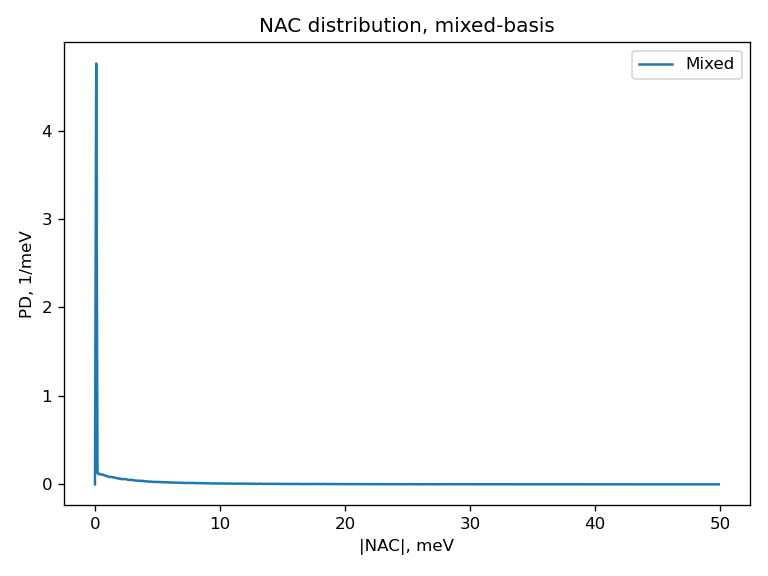

In [5]:
%matplotlib notebook

for basis in ['sd']:
    nac = []
    nac_files = glob.glob(F'res-mixed-basis-xTB/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp, dens, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp, dens, label='Mixed')
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution, mixed-basis')
plt.legend()
plt.tight_layout()
# plt.savefig('nac_dist_1.jpg', dpi=600)

### 4.2. Energy vs time <a name='ene_time'></a>
Here, we plot the excited states energy vs time. Since the excited states were sorted by their `'identity'` it is easy to visualize the states energies crossings.

<IPython.core.display.Javascript object>


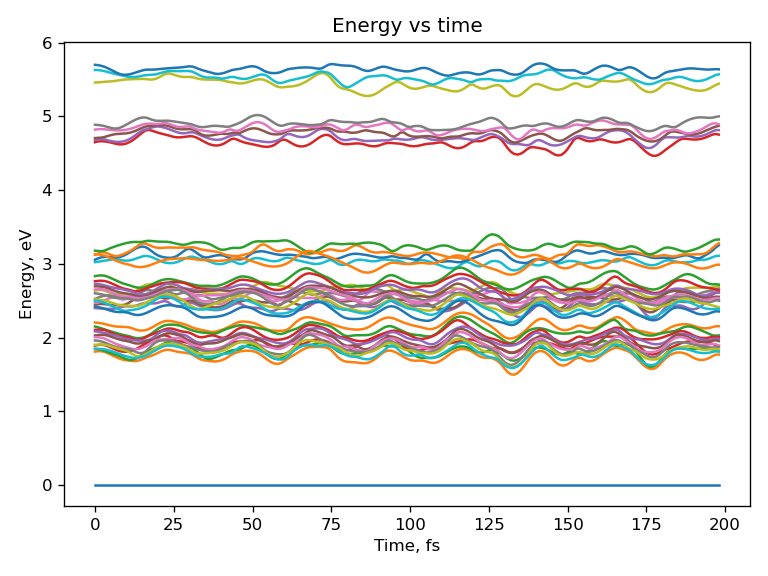

In [6]:
%matplotlib notebook
energy_files = glob.glob('res-mixed-basis-xTB/Hvib_sd*re*')
energy_files = data_io.sort_hvib_file_names(energy_files)
#print('Sorted energy files are:', energy_files)
dt = 1.0 # fs
energies = []
for file in energy_files:
    energies.append(np.diag(sp.load_npz(file).todense().real))
energies = np.array(energies)*units.au2ev
md_time = np.arange(0,energies.shape[0]*dt,dt)
#print(energies.shape)
for i in range(energies.shape[1]):
    plt.plot(md_time, energies[:,i]-energies[:,0])
plt.title('Energy vs time')
plt.ylabel('Energy, eV')
plt.xlabel('Time, fs')
plt.tight_layout()

### 4.3. NAC map <a name='nac_map'></a>
Another way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`.

<IPython.core.display.Javascript object>


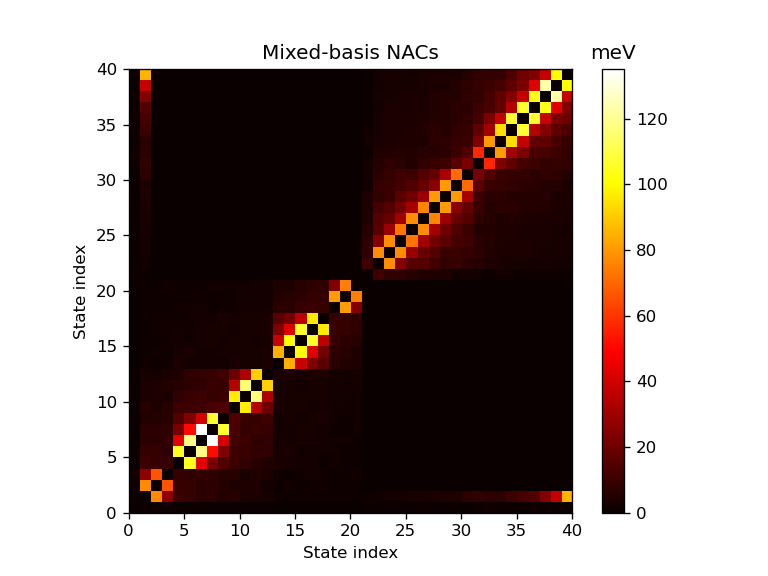

Text(0.5, 1.0, 'Mixed-basis NACs')

In [7]:
%matplotlib notebook
nac_files = glob.glob('res-mixed-basis-xTB/Hvib_sd*im*')
for c, nac_file in enumerate(nac_files):
    nac_mat = sp.load_npz(nac_file).todense().real
    if c==0:
        nac_ave = np.zeros(nac_mat.shape)
    nac_ave += np.abs(nac_mat)
nac_ave *= 1000*units.au2ev/c
nstates = nac_ave.shape[0]
plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=150)
plt.xlabel('State index')
plt.ylabel('State index')
plt.colorbar().ax.set_title('meV')
plt.title('Mixed-basis NACs')

### 4.4. Average partial density of states <a name='ave_pdos'></a>
In this section, we will plot the average partial density of states (pDOS) over the MD trajectory. There are two ways to take the average of the pDOS:

1- Average all the pDOS files and then convolve the average pDOS for each element.
2- Convolve the pDOS files and then take the average for each element.

We choose the first one due to two reasons. First, the computational cost is much lower and we only need one convolution. Second is that averaging over the grid points (using the method 2) is dependent on the number of grid points we use for convolution which again adds to the complexity of the procedure. 

Here, we will use normalized Gaussian function for weighting the pDOS values and summing them.

$$f(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

This function is defined in the `gaussian_function` below. To apply this to a vector of numbers and sum all the weighted Gaussians, we use the `gaussian_function_vector` which will be used for pDOS plots.

In [8]:
def gaussian_function(a, mu, sigma, num_points, x_min, x_max):
    pre_fact = (a/sigma)/(np.sqrt(2*np.pi))
    x = np.linspace(x_min, x_max, num_points)
    x_input = np.array((-1/2)/(np.square(sigma))*np.square(x-mu))
    gaussian_fun = pre_fact*np.exp(x_input)
    
    return x, gaussian_fun
    
def gaussian_function_vector(a_vec, mu_vec, sigma, num_points, x_min, x_max):
    for i in range(len(a_vec)):
        if i==0:
            sum_vec = np.zeros(num_points)
        energy_grid, conv_vec = gaussian_function(a_vec[i], mu_vec[i], sigma, num_points, x_min, x_max)
        sum_vec += conv_vec
    return energy_grid, sum_vec


#### 4.4.1. Plot pDOS for all atoms angular momentums <a name='ave_pdos_1'></a>

In this part, we plot the pDOS for all of the angular momentum components of each atom. This is done by using the `orbital_cols`. In fact, the `orbital_cols` is related to `orbitals`. For example, for `s` orbital, we consider the 3rd index and for `p` orbital, we sum the columns from 4 to 6 (`range(4,7)`). Here we want to show how the code works and how the you can modify that based on your project. In the next section, we will show the pDOS only for atoms and sum all the components in each row of the pdos file. Other parameters are as follows:

`atoms`: The atoms names which will be used in the labeling and plotting. The atoms order should be exactly the same as appear in the `.pdos` files. For example, the `*k1*.pdos` files contain the pDOS data for `N` atom and `*k2*.pdos` files contain the data for the `N` atom.

`npoints`: The number of grid points for making the Gaussian functions. Note that, this value should be more than the number of states in the `.pdos` files.

`sigma`: The standard deviation in eV.

`shift`: This value shifts the minimum and maximum energy found in the `pdos_ave` and will extend the boundaries from both sides by `shift`eV.

Finally, we will plot the total density of states. Note that the HOMO energy level is set to zero.

<IPython.core.display.Javascript object>


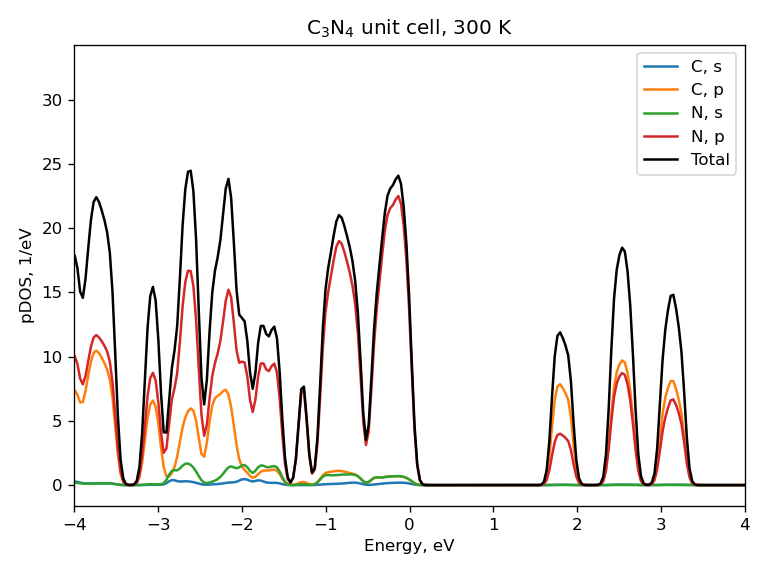

In [10]:
%matplotlib notebook
path_to_all_pdos = os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_pdosfiles'
atoms = ['C', 'N']
orbitals_cols = [[3], range(4,7), range(7,12), range(12,19)]
orbitals = ['s','p','d','f']
npoints = 1000
sigma = 0.05 # eV
shift = 2.0 # eV
ave_pdos_convolved_all = []
for c1,i in enumerate([1,2]):
    pdos_files = glob.glob(path_to_all_pdos+F'/*k{i}*.pdos')
    for c2, pdos_file in enumerate(pdos_files):
        pdos_mat = np.loadtxt(pdos_file)
        if c2==0:
            pdos_ave = np.zeros(pdos_mat.shape)
        pdos_ave += pdos_mat
    pdos_ave /= c2+1
    pdos_ave[:,1] *= units.au2ev
    e_min = np.min(pdos_ave[:,1])-shift
    e_max = np.max(pdos_ave[:,1])+shift
    homo_level = np.max(np.where(pdos_ave[:,2]==2.0))
    homo_energy = pdos_ave[:,1][homo_level]
    for c3, orbital_cols in enumerate(orbitals_cols):
        try:
            sum_pdos_ave = np.sum(pdos_ave[:,orbital_cols],axis=1)
            ave_energy_grid, ave_pdos_convolved = gaussian_function_vector(sum_pdos_ave, pdos_ave[:,1], sigma,
                                                                               npoints, e_min, e_max)
            ave_pdos_convolved_all.append(ave_pdos_convolved)
            pdos_label = atoms[c1]+F', {orbitals[c3]}'
            plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved, label=pdos_label)
        except:
            pass


ave_pdos_convolved_total = np.sum(np.array(ave_pdos_convolved_all),axis=0)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend()
plt.xlim(-4,4)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('C$_3$N$_4$ unit cell, 300 K')
plt.tight_layout()

#### 4.4.2. Plot pDOS for atoms with no angular momentum component <a name='ave_pdos_2'></a>
As you can see we have removed the `for` loop for the `orbital_cols` and in the `try` section we have set `sum_pdos_ave = np.sum(pdos_ave[:,3::],axis=1)` which will sum all the columns from 3rd index (`pdos_ave[:,3::]`).

<IPython.core.display.Javascript object>


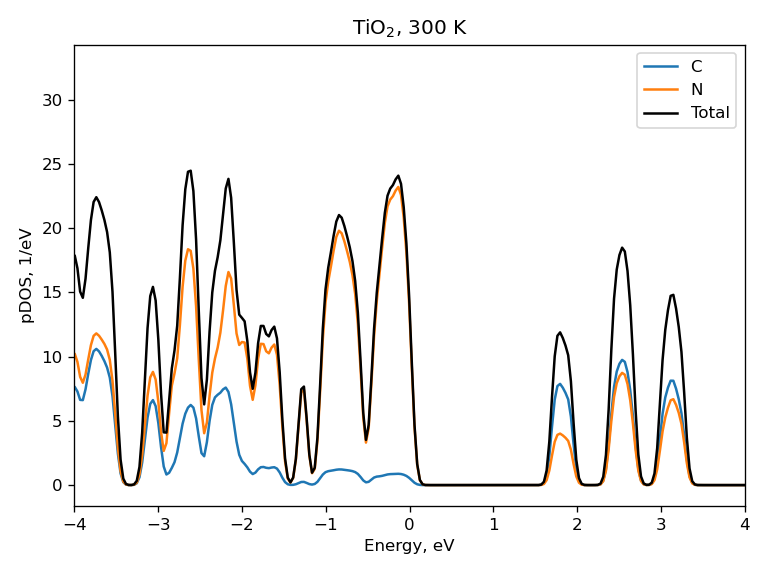

In [11]:
%matplotlib notebook
path_to_all_pdos = os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_pdosfiles'
atoms = ['C', 'N']
npoints = 1000
sigma = 0.05
shift = 2.0 # eV
ave_pdos_convolved_all = []
for c1,i in enumerate([1,2]):
    pdos_files = glob.glob(path_to_all_pdos+F'/*k{i}*.pdos')
    for c2, pdos_file in enumerate(pdos_files):
        pdos_mat = np.loadtxt(pdos_file)
        if c2==0:
            pdos_ave = np.zeros(pdos_mat.shape)
        pdos_ave += pdos_mat
    pdos_ave /= c2+1
    pdos_ave[:,1] *= units.au2ev
    e_min = np.min(pdos_ave[:,1])-shift
    e_max = np.max(pdos_ave[:,1])+shift
    homo_level = np.max(np.where(pdos_ave[:,2]==2.0))
    homo_energy = pdos_ave[:,1][homo_level]
    try:
        sum_pdos_ave = np.sum(pdos_ave[:,3::],axis=1)
        ave_energy_grid, ave_pdos_convolved = gaussian_function_vector(sum_pdos_ave, pdos_ave[:,1], sigma,
                                                                           npoints, e_min, e_max)
        ave_pdos_convolved_all.append(ave_pdos_convolved)
        pdos_label = atoms[c1]
        plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved, label=pdos_label)
    except:
        pass


ave_pdos_convolved_total = np.sum(np.array(ave_pdos_convolved_all),axis=0)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend()
plt.xlim(-4,4)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('TiO$_2$, 300 K')
plt.tight_layout()